In [54]:
import pandas as pd
import numpy as np
import glob, subprocess, os, tqdm, copy, re 
import xml.etree.ElementTree as ET
from PIL import ImageFont
from matplotlib import pyplot as plt 

In [55]:
cd /home/andre/Projects/home/alfabeto

/home/andre/Projects/home/alfabeto


In [56]:
cardw, cardh = 70.5, 48.9 # card size 
columncolors = ['#a9d18e', '#ffe699', '#8faadc', '#f4b183'] # rect fill color fill:#a9d18e columns

def textbox(text, size=16, fontfile="FreeSerif.ttf", stroke_width=0.25):
    font = ImageFont.truetype(fontfile, size=size)  
    w, h = font.getsize(text, stroke_width=stroke_width)
    return [w, h]

def optimize_fontsize(text, maxw, maxh, default_size=17):
    # generate sample data to interpolate (4 points)
    # text area width  vs font size    
    # text area height vs font size
    pts = np.array([ [ size ] + textbox(text, size) for size in np.arange(default_size-8, default_size+8, 3) ])     
    gap = 0.15 # 15% of gap 
    w_interp = np.poly1d(np.polyfit(pts[:, 1], pts[:, 0], 1)) # (width, font_size) interpolator 
    fw = w_interp(int(cardw*(1-gap))) # get font size for 90% height 
    h_interp = np.poly1d(np.polyfit(pts[:, 2], pts[:, 0], 1)) # (height, font_size) interpolator 
    fh = h_interp(int(cardh*(1-gap))) # get font size for 90% width 
    #print(f"{text} w:{fw:.1f}, h:{fh:.1f}")
    return round(min(fw, fh),2)

def make_card_svg(etree_master, 
            card_words, 
            filename, 
            font_family='FreeSerif', 
            upper=True,
            lower=True):
    def text_set_style(etext, font_family):       
        fontsize = optimize_fontsize(etext.text, cardw, cardh) if etext.text else 17 # avoiding '' strings     
        # https://stackoverflow.com/q/2973436/1207193 positive look behind           
        etext.set('style', re.sub("(?<=font-size:)[\d\.]+", str(fontsize), etext.attrib['style'])) # change font-size 
        etext.set('style', re.sub("(?<=font-family:)\w+", font_family, etext.attrib['style'])) # change font-family         
        #font-family:FreeSerif    
    def rect_set_color(erect, colorhex):
        erect.set('style', re.sub("(?<=fill:)[#abcdef\d]+", colorhex, erect.attrib['style'])) # change fillcolor  
    def set_words_write(etree, words, font_family, colors, fname):
        etree = copy.deepcopy(etree)
        for i, g in enumerate(etree.findall(".//{*}g")[1:]): # ignore first group: layer
            erect, etext = list(g) # each group has rect followed by a text 
            etext.text = words[i]
            text_set_style(etext, font_family)    
            rect_set_color(erect, colors[i])
        etree.write(fname+".svg", encoding="UTF-8")     
    nwords = np.array(card_words)    
    if upper: # first page UPPER case    
        set_words_write(etree_master, 
            list(map(str.upper, nwords)),
            font_family, columncolors*4,  # 4xrows =16           
            filename)
    if lower: # second page LOWER case - verse          
        nwords = nwords.reshape((4,4)) # create ndarray of 4x4 columns    
        nwords = np.apply_along_axis(lambda x: x[::-1], -1, nwords) # invert rows 
        nwords = nwords.flatten()
        set_words_write(etree_master, 
            list(map(str.lower, nwords)),
            font_family, columncolors[::-1]*4, # also invert colors    
            filename+'v')

#### 1. Read excel and prepare content for printing 

#### 2. Create as many svg files as needed names are card1, card1v, card2, card2v ... 

A4 landscape

#### 3. Then convert svgs to pdf and merge them 

In [ ]:
cards = pd.read_excel('words/words.xlsx', header=0)
cards = cards.convert_dtypes()
cards.fillna('', inplace=True)
cards

In [ ]:
def make_cards(cardwords, filename, font='FreeSerif', verbose=True, upper=True, lower=True):
    data = cardwords
    # complete page to have 16 elements
    if len(data)%16 != 0:
        data = np.append(data, ['']*(16-len(data)%16))
        data[data == 'nan'] = ''
    data = data.reshape((-1, 16)) # see number many pages
    if verbose:
        print(data[-5:])
        print("number of pages: ", data.shape[0])
    # parse xml and get svg text tag to replace text
    etree_master = ET.parse('svg/word_cards_main.svg') # original and reference card file to replace text  
    # generate as many svg files as needed names are card1, card1v, card2, card2v ... 
    for i, pg_data in tqdm.tqdm(enumerate(data), total=len(data)):
        make_card_svg(etree_master, pg_data, f"card{i+1:03d}", font_family=font, upper=upper, lower=lower)
    for svgfile in tqdm.tqdm(sorted(glob.glob("card*.svg"))):
        name = svgfile.replace('.svg', '')
        ok = subprocess.run(f"/usr/bin/inkscape --export-filename={name}.pdf {name}.svg", shell=True)
        if not isinstance(ok, subprocess.CompletedProcess):
            print("Erro!")
    # shell=True to use wildcards * and dont need to .split(' ')
    subprocess.run(f"/usr/bin/pdftk card*.pdf cat output {filename}.pdf", shell=True) 
    subprocess.run(f"rm card*.pdf card*.svg", shell=True) # clean up svgs pdfs
    subprocess.run(f"mv {filename}.pdf prontos", shell=True)

font = 'MamaeQueNosFaz'
font = 'FreeSerif'
cardsgby = cards.groupby(cards.grupo)
grupos = list(cardsgby.groups.keys()) # todos os cards nomes
# grupos = ['silabário'] # choosing only one

# one pdf for each grupo
# for grupo in tqdm.tqdm(grupos):
#     fname = re.sub(r'[,\- ]+', '_', grupo.lower()) # making acceptable file names     
#     cardata = cardsgby.get_group(grupo).iloc[:, :4].values.flatten()
#     make_cards(cardata, fname, font=font, upper=True, verbose=True)

# better every grupo packed together on same pdf
cardata = cards.iloc[:, :4].values.flatten().tolist()
cardata = np.array([value for value in cardata if value != ''])
make_cards(cardata, 'todoscards', font=font, upper=True, verbose=True) 

Playing with font with font size pixel and glyph sizes

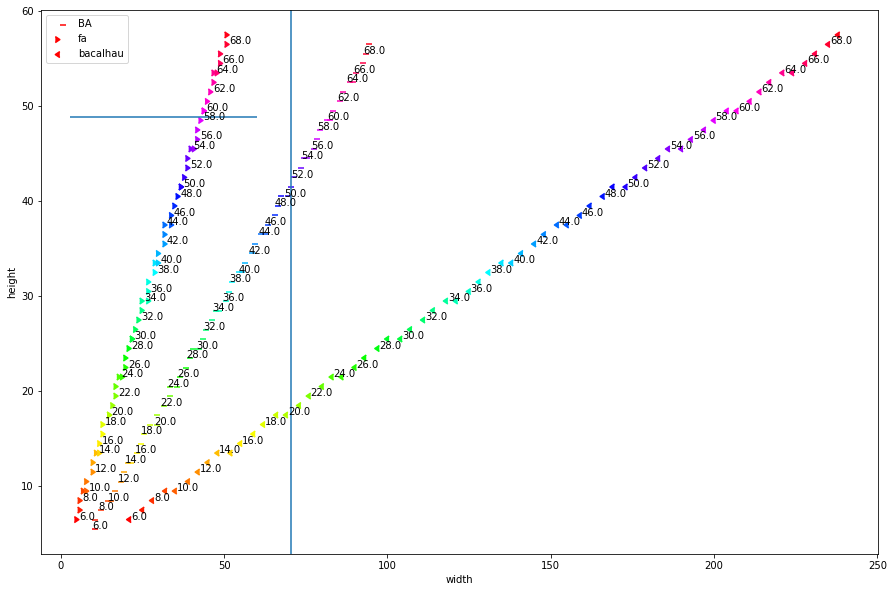

In [59]:
#%matplotlib widget
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)#, projection='3d')

for word in ['BA', 'fa', 'bacalhau']: # pixels equivalent to mm in my case
    vs = [] 
    for size in np.arange(6, 70, 1):
        w, h = textbox(word, int(size))
        vs.append([size, w, h])
        #print('w, h: ', w, h, ' for word: ', word)
    vs = np.array(vs)
    ax.scatter(vs[:, 1], vs[:, 2], c=vs[:, 0], marker=np.random.randint(0, 10), label=word, cmap='hsv')
    for i in range(0, len(vs), 2):
        ax.annotate(f"{vs[i, 0]}", (vs[i, 1], vs[i, 2]))
ax.set_xlabel('width')
ax.set_ylabel('height')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.vlines(cardw, *xlim)
ax.hlines(cardh, *ylim)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()